In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

df_filled = pd.read_csv("../preprocessing/train_cleaned.csv")

target = 'SalePrice'
cols_to_exclude = [target, "Id"]
features = [col for col in df_filled.select_dtypes(include=[np.number]).columns 
            if col not in cols_to_exclude]

X = df_filled[features]
y = df_filled[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# evaluation function
def evaluate_model(y_acc, y_pred):
    mae = mean_absolute_error(y_acc, y_pred)
    mse = mean_squared_error(y_acc, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_acc, y_pred)
    mape = np.mean(np.abs((y_acc - y_pred) / y_acc)) * 100
    rmse_pct = (rmse / y_acc.mean()) * 100

    # return instead of printing metrics
    return {
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'RMSE%': rmse_pct
    }

In [43]:
def plot_ablation_changes(results_df, ablation_type):
    baseline_value = 0.913898
    
    pct_changes = (results_df['R²'] - baseline_value) * 100
    
    mask = ~results_df.index.str.startswith('Baseline')
    pct_changes = pct_changes[mask]
    
    pct_changes = pct_changes.sort_values()
    
    plt.figure(figsize=(16, 9))
    bars = plt.barh(range(len(pct_changes)), pct_changes.values, 
                    color='red', 
                    alpha=0.7)
    
    plt.yticks(range(len(pct_changes)), pct_changes.index, fontsize=10)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
    plt.xlabel('% Change from Baseline', fontsize=12)
    plt.title(f'R² Changes from Baseline: {ablation_type}', 
              fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='x', alpha=0.3)
    
    for i, value in enumerate(pct_changes.values):
        label_x = value
        plt.text(label_x, i, f'{value:+.1f}%', 
                va='center', ha='left' if value > 0 else 'right',
                fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    return pct_changes

In [9]:
def ablation_study_gbr(X_train, X_test, y_train, y_test):
    """
    Ablation study for Gradient Boosting hyperparameters.
    """
    # store the results of all variations in the results dictionary for later reference
    results = {}

    best_params = {
        'learning_rate': 0.05263727095314413, 
        'max_depth': 4, 
        'n_estimators': 799}

    print("Training optimized baseline model...")
    gbr = GradientBoostingRegressor(random_state=42, 
                                    learning_rate=best_params["learning_rate"], 
                                    max_depth=best_params["max_depth"], 
                                    n_estimators=best_params["n_estimators"])
    gbr.fit(X_train, y_train)
    y_gbr_pred = gbr.predict(X_test)
    # store baseline results
    results['Baseline (Full Optimized)'] = evaluate_model(y_test, y_gbr_pred)

    # ABLATION 1: Learning Rate
    print("\nTesting learning rate variations...")
    learning_rates = [0.01, 0.08, 0.1, 0.15, 0.2, 0.3, 1]
    for rate in learning_rates:
        gbr = GradientBoostingRegressor(random_state=42,
                                        learning_rate=rate,
                                        max_depth=best_params["max_depth"], 
                                        n_estimators=best_params["n_estimators"])
        gbr.fit(X_train, y_train)
        y_gbr_pred = gbr.predict(X_test)
        results[f'Learning Rate={rate}'] = evaluate_model(y_test, y_gbr_pred)

    # ABLATION 2: Max Depth
    print("\nTesting maximum depth variations...")
    depths = [2, 3, 5, 6, 10]
    for depth in depths:
        gbr = GradientBoostingRegressor(random_state=42,
                                        learning_rate=best_params["learning_rate"], 
                                        max_depth=depth, 
                                        n_estimators=best_params["n_estimators"])
        gbr.fit(X_train, y_train)
        y_gbr_pred = gbr.predict(X_test)
        results[f'Max Depth={depth}'] = evaluate_model(y_test, y_gbr_pred)

    # ABLATION 3: Estimators
    print("\nTesting number of estimators variations...")
    num_estims = [100, 300, 500, 700, 1000, 1500]
    for n_e in num_estims:
        gbr = GradientBoostingRegressor(random_state=42,
                                        learning_rate=best_params["learning_rate"], 
                                        max_depth=best_params["max_depth"], 
                                        n_estimators=n_e)
        gbr.fit(X_train, y_train)
        y_gbr_pred = gbr.predict(X_test)
        results[f'Number of Estimators={n_e}'] = evaluate_model(y_test, y_gbr_pred)

    # ABLATION 4: Add Standard Scaling
    print("\nTesting with StandardScaler...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    gbr = GradientBoostingRegressor(random_state=42, 
                                    learning_rate=best_params["learning_rate"], 
                                    max_depth=best_params["max_depth"], 
                                    n_estimators=best_params["n_estimators"])
    gbr.fit(X_train_scaled, y_train)
    y_gbr_pred = gbr.predict(X_test_scaled)
    results['With StandardScaler'] = evaluate_model(y_test, y_gbr_pred)

    # ABLATION 5: All default GradientBoostingRegressor settings, no tuning
    print("\nTesting vanilla model (all default hyperparameters)...")
    gbr = GradientBoostingRegressor(random_state=42)
    gbr.fit(X_train, y_train)
    y_gbr_pred = gbr.predict(X_test)
    results[f'Vanilla Model'] = evaluate_model(y_test, y_gbr_pred)

    return results

In [10]:
results = ablation_study_gbr(X_train, X_test, y_train, y_test)
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R²', ascending=False)
results_df

Training optimized baseline model...

Testing learning rate variations...

Testing maximum depth variations...

Testing number of estimators variations...

Testing with StandardScaler...

Testing vanilla model (all default hyperparameters)...


,R²,RMSE,MAE,MAPE,RMSE%
Max Depth=3,0.914045,25676.854693,15582.303228,9.413550,14.357460
Baseline (Full Optimized),0.913898,25698.782004,15754.986096,9.587494,14.369721
With StandardScaler,0.913857,25704.946220,15757.572373,9.582025,14.373168
Number of Estimators=1000,0.913681,25731.159088,15780.146106,9.616377,14.387825
Number of Estimators=700,0.913495,25758.874690,15773.099278,9.575230,14.403322
Number of Estimators=1500,0.913399,25773.230751,15823.404054,9.676371,14.411350
Max Depth=5,0.913334,25782.913727,16062.317076,9.820671,14.416764
Number of Estimators=300,0.913104,25817.066914,15886.225729,9.545439,14.435861
Number of Estimators=500,0.912868,25852.059727,15875.674535,9.590807,14.455428
Learning Rate=0.01,0.910620,26183.412453,16193.160572,9.821762,14.640707


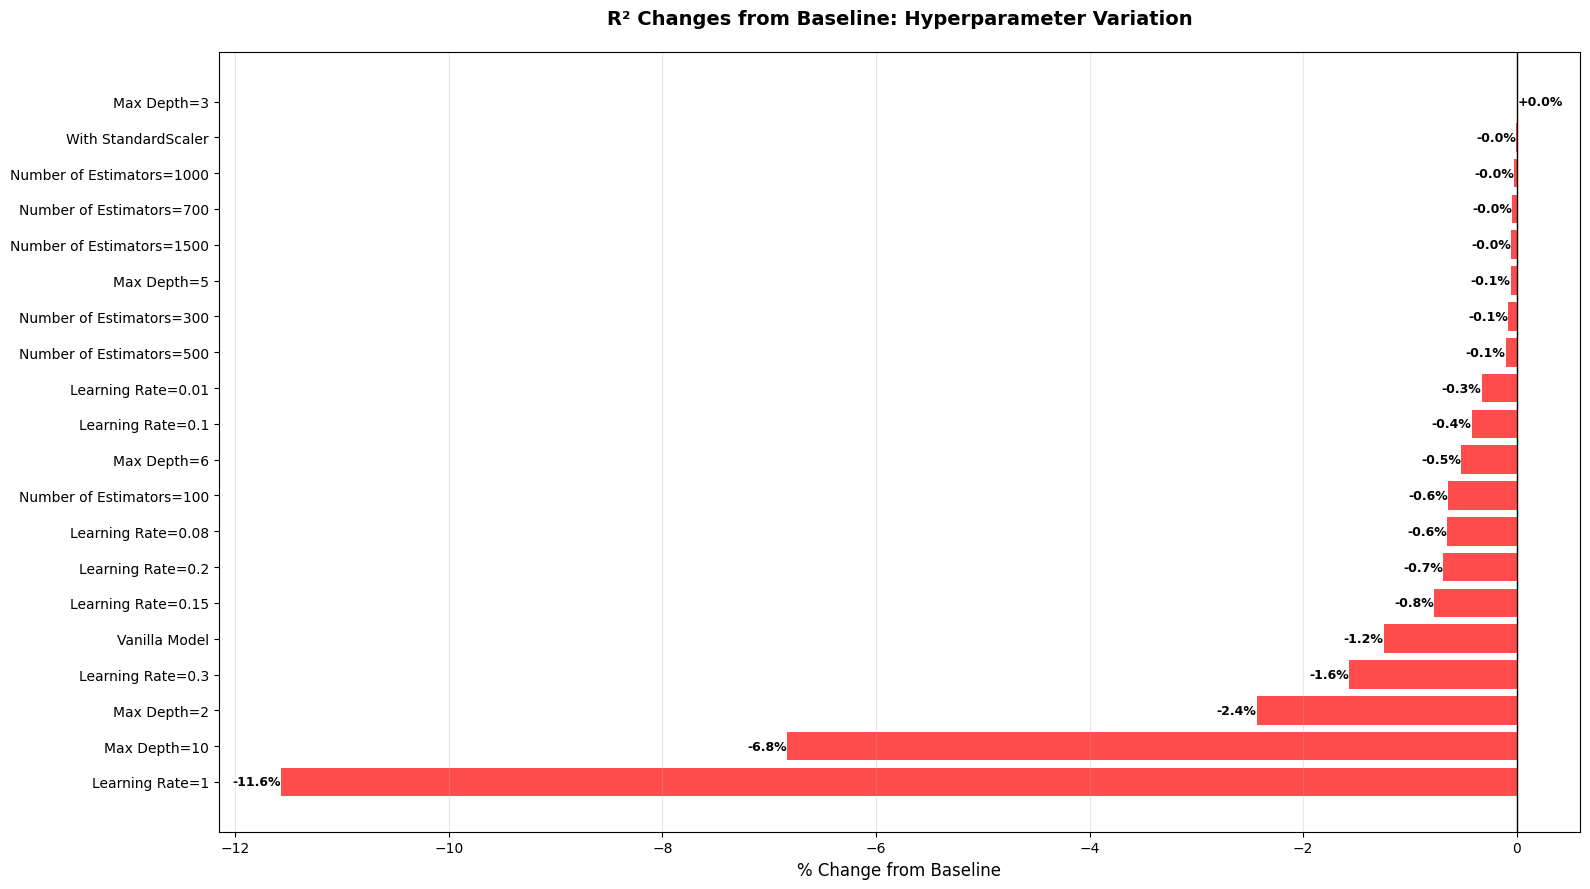

In [44]:
pct_changes_df = plot_ablation_changes(results_df, "Hyperparameter Variation")
plt.show()

In [27]:
def get_feature_categories(all_features):
    """
    Returns a dictionary mapping category names to lists of features to remove.
    """
    categories = {}
    
    categories['Property Basics'] = [
        'MSSubClass', 'LotFrontage', 'LotArea', 'LotShape', 'Utilities', 'LandSlope'
    ]
    
    location_prefixes = ['MSZoning_', 'Street_', 'LandContour_', 'LotConfig_', 
                        'Neighborhood_', 'Condition1_', 'Condition2_']
    categories['Location'] = [f for f in all_features if any(f.startswith(p) for p in location_prefixes)]
    
    building_prefixes = ['BldgType_', 'HouseStyle_', 'RoofStyle_', 'RoofMatl_']
    categories['Building Type & Style'] = [f for f in all_features if any(f.startswith(p) for p in building_prefixes)]
    
    exterior_prefixes = ['Exterior1st_', 'Exterior2nd_', 'MasVnrType_']
    categories['Exterior'] = [f for f in all_features if any(f.startswith(p) for p in exterior_prefixes)] + ['MasVnrArea']
    
    foundation_heating_prefixes = ['Foundation_', 'Heating_']
    categories['Foundation, Heating & Electrical'] = [f for f in all_features if any(f.startswith(p) for p in foundation_heating_prefixes)] + ['HeatingQC', 'CentralAir', 'Electrical']
    
    categories['Quality & Condition Ratings'] = [
        'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'KitchenQual', 'HeatingQC', 'Functional'
    ]
    
    categories['Age & Remodeling'] = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
    
    categories['Basement'] = [
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
        'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'
    ]
    
    categories['Living Space & Kitchen'] = [
        '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'KitchenAbvGr', 'KitchenQual'
    ]
    
    categories['Bathrooms & Bedrooms'] = [
        'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr'
    ]
    
    garage_prefixes = ['GarageType_']
    categories['Garage'] = [f for f in all_features if any(f.startswith(p) for p in garage_prefixes)] + [
        'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond'
    ]
    
    outdoor_prefixes = ['Alley_', 'Fence_']
    categories['Outdoor Features'] = [f for f in all_features if any(f.startswith(p) for p in outdoor_prefixes)] + [
        'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
    ]
    
    misc_prefixes = ['MiscFeature_']
    categories['Special Features'] = [f for f in all_features if any(f.startswith(p) for p in misc_prefixes)] + [
        'PoolArea', 'PoolQC', 'Fireplaces', 'FireplaceQu', 'MiscVal'
    ]
    
    sale_prefixes = ['SaleType_', 'SaleCondition_']
    categories['Sale Information'] = [f for f in all_features if any(f.startswith(p) for p in sale_prefixes)] + [
        'MoSold', 'YrSold'
    ]
    
    return categories

In [28]:
def ablation_study_features(X_train, X_test, y_train, y_test):
    """
    Ablation study that removes categories one at a time.
    """
    results = {}

    best_params = {
        'learning_rate': 0.05263727095314413, 
        'max_depth': 4, 
        'n_estimators': 799}

    feature_categories = get_feature_categories(X_train.columns.tolist())

    # Baseline: ALL features
    print("Training baseline model with all features...")
    gbr = GradientBoostingRegressor(random_state=42, 
                                    learning_rate=best_params["learning_rate"], 
                                    max_depth=best_params["max_depth"], 
                                    n_estimators=best_params["n_estimators"])
    gbr.fit(X_train, y_train)
    y_gbr_pred = gbr.predict(X_test)
    # store baseline results
    results['Baseline (All Features)'] = evaluate_model(y_test, y_gbr_pred)

    # Ablations in which one category is removed and the effect is examined
    for category_name, features_to_remove in feature_categories.items():
        print(f"\nRemoving {category_name} ({len(features_to_remove)} features)...")
        # drop a category of features
        features_to_drop = [f for f in features_to_remove if f in X_train.columns]
        X_train_reduced = X_train.drop(columns=features_to_drop)
        X_test_reduced = X_test.drop(columns=features_to_drop)
        gbr = GradientBoostingRegressor(random_state=42, 
                                    learning_rate=best_params["learning_rate"], 
                                    max_depth=best_params["max_depth"], 
                                    n_estimators=best_params["n_estimators"])
        gbr.fit(X_train_reduced, y_train)
        y_gbr_pred = gbr.predict(X_test_reduced)
        # store baseline results
        results[f'Dropped {category_name}'] = evaluate_model(y_test, y_gbr_pred)

    return results

In [29]:
feature_results = ablation_study_features(X_train, X_test, y_train, y_test)

feature_results_df = pd.DataFrame(feature_results).T
feature_results_df = feature_results_df.sort_values('R²', ascending=False)
feature_results_df

Training baseline model with all features...

Removing Property Basics (6 features)...

Removing Location (58 features)...

Removing Building Type & Style (27 features)...

Removing Exterior (35 features)...

Removing Foundation, Heating & Electrical (15 features)...

Removing Quality & Condition Ratings (7 features)...

Removing Age & Remodeling (3 features)...

Removing Basement (11 features)...

Removing Living Space & Kitchen (7 features)...

Removing Bathrooms & Bedrooms (5 features)...

Removing Garage (12 features)...

Removing Outdoor Features (12 features)...

Removing Special Features (9 features)...

Removing Sale Information (17 features)...


,R²,RMSE,MAE,MAPE,RMSE%
Dropped Exterior,0.914990,25535.292504,15942.997371,9.630023,14.278304
Dropped Sale Information,0.914016,25681.281174,15885.186755,9.499649,14.359935
"Dropped Foundation, Heating & Electrical",0.913944,25691.922930,15647.441584,9.378889,14.365886
Baseline (All Features),0.913898,25698.782004,15754.986096,9.587494,14.369721
Dropped Age & Remodeling,0.912856,25853.941090,15693.737671,9.539425,14.456480
Dropped Bathrooms & Bedrooms,0.911674,26028.600156,15969.553329,9.724633,14.554142
Dropped Outdoor Features,0.909740,26312.073260,15906.059489,9.581609,14.712649
Dropped Basement,0.908083,26552.456318,16876.747046,10.563871,14.847061
Dropped Location,0.906307,26807.761783,16958.387380,10.542437,14.989818
Dropped Building Type & Style,0.905851,26872.928216,16000.225387,9.689349,15.026256


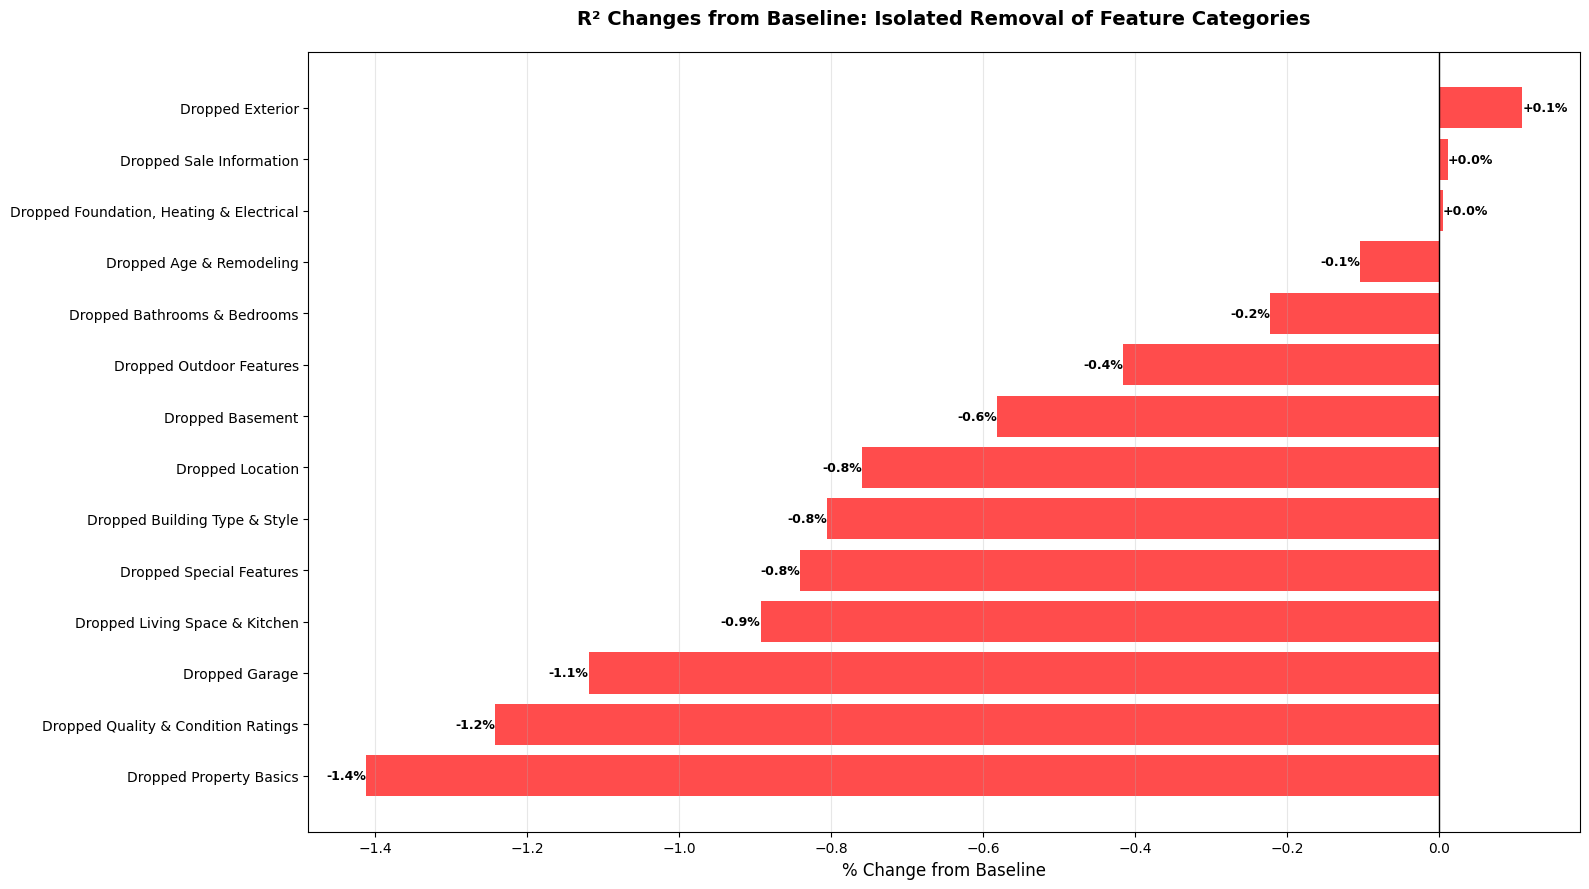

In [45]:
pct_changes_df = plot_ablation_changes(feature_results_df, "Isolated Removal of Feature Categories")
plt.show()

In [37]:
def ablation_study_incremental(X_train, X_test, y_train, y_test):
    """
    Incremental feature addition: Start with most essential, add one category at a time.
    """
    results = {}

    best_params = {
        'learning_rate': 0.05263727095314413, 
        'max_depth': 4, 
        'n_estimators': 799}
    
    feature_categories = get_feature_categories(X_train.columns.tolist())
    
    # Order from most essential to least (based on previous ablation results)
    category_order = [
        'Property Basics',
        'Quality & Condition Ratings',
        'Garage',
        'Living Space & Kitchen',
        'Special Features',
        'Building Type & Style',
        'Location',
        'Basement',
        'Outdoor Features',
        'Bathrooms & Bedrooms',
        'Age & Remodeling',
        'Foundation, Heating & Electrical',
        'Sale Information',
        'Exterior'
    ]
    
    features_to_include = []
    
    # Incrementally add categories
    for i, category_name in enumerate(category_order):
        category_features = feature_categories[category_name]
        category_features_exist = [f for f in category_features if f in X_train.columns]
        features_to_include.extend(category_features_exist)
        
        print(f"\n[{i+1}/14] Training with {category_name} ({len(features_to_include)} total features)...")
        
        X_train_subset = X_train[features_to_include]
        X_test_subset = X_test[features_to_include]
        
        gbr = GradientBoostingRegressor(
            random_state=42,
            learning_rate=best_params["learning_rate"],
            max_depth=best_params["max_depth"],
            n_estimators=best_params["n_estimators"]
        )
        gbr.fit(X_train_subset, y_train)
        y_gbr_pred = gbr.predict(X_test_subset)
        
        results[f'Up to {category_name}'] = evaluate_model(y_test, y_gbr_pred)
    
    return results

In [38]:
incremental_results = ablation_study_incremental(X_train, X_test, y_train, y_test)

incremental_df = pd.DataFrame(incremental_results).T
incremental_df = incremental_df.sort_values('R²', ascending=False)
incremental_df


[1/14] Training with Property Basics (6 total features)...

[2/14] Training with Quality & Condition Ratings (13 total features)...

[3/14] Training with Garage (25 total features)...

[4/14] Training with Living Space & Kitchen (32 total features)...

[5/14] Training with Special Features (41 total features)...

[6/14] Training with Building Type & Style (68 total features)...

[7/14] Training with Location (126 total features)...

[8/14] Training with Basement (137 total features)...

[9/14] Training with Outdoor Features (149 total features)...

[10/14] Training with Bathrooms & Bedrooms (154 total features)...

[11/14] Training with Age & Remodeling (157 total features)...

[12/14] Training with Foundation, Heating & Electrical (172 total features)...

[13/14] Training with Sale Information (189 total features)...

[14/14] Training with Exterior (224 total features)...


,R²,RMSE,MAE,MAPE,RMSE%
Up to Basement,0.919155,24901.946632,15439.282863,9.179748,13.924163
Up to Outdoor Features,0.915220,25500.844918,15681.255301,9.242820,14.259043
Up to Bathrooms & Bedrooms,0.912944,25840.824843,15806.708670,9.396133,14.449146
Up to Exterior,0.912674,25880.930205,15789.248610,9.635802,14.471571
Up to Age & Remodeling,0.910487,26202.898103,16032.269289,9.311846,14.651602
"Up to Foundation, Heating & Electrical",0.909468,26351.705733,16314.147195,9.662818,14.734810
Up to Sale Information,0.905346,26944.862723,16165.040121,9.661474,15.066479
Up to Location,0.901462,27492.097658,17976.863443,10.661764,15.372471
Up to Building Type & Style,0.896096,28230.821731,19057.514752,11.989146,15.785535
Up to Special Features,0.889577,29102.923224,19648.230653,12.325915,16.273179


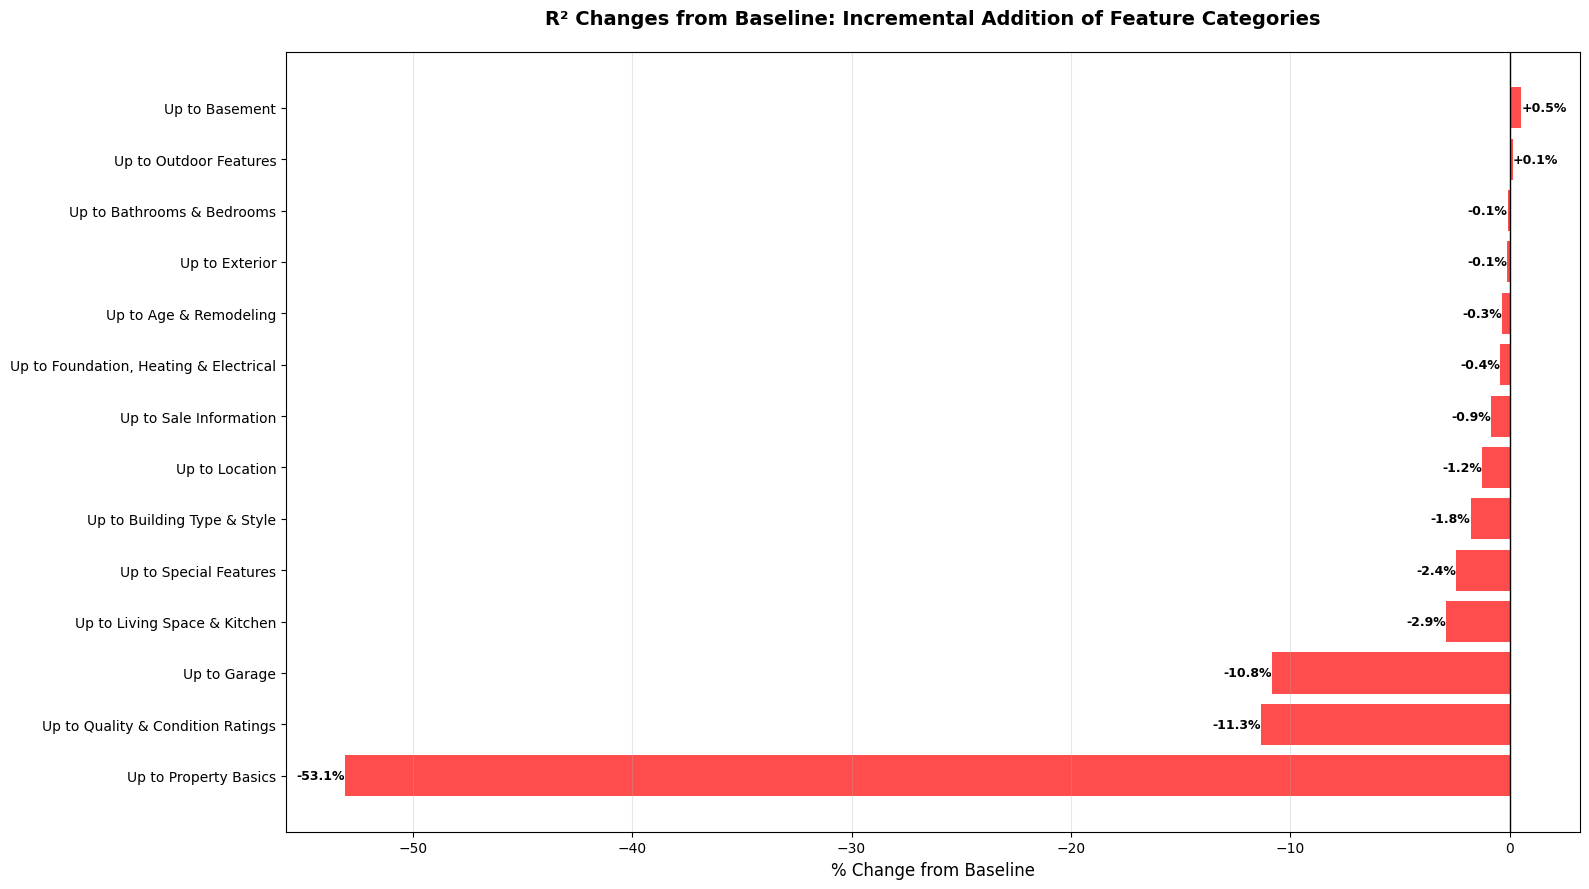

In [46]:
pct_changes_df = plot_ablation_changes(incremental_df, "Incremental Addition of Feature Categories")
plt.show()

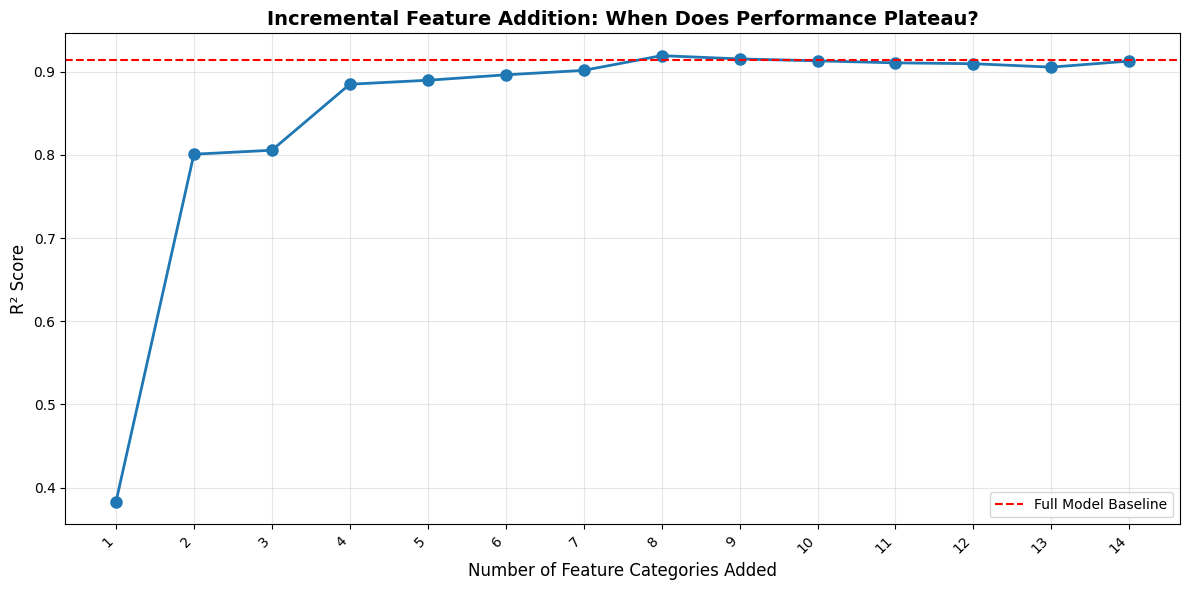

In [33]:
# Plot to see where performance plateaus
plt.figure(figsize=(12, 6))
plt.plot(range(1, 15), incremental_df['R²'], marker='o', linewidth=2, markersize=8)
plt.axhline(y=0.9139, color='red', linestyle='--', label='Full Model Baseline')
plt.xlabel('Number of Feature Categories Added', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Incremental Feature Addition: When Does Performance Plateau?', fontsize=14, fontweight='bold')
plt.xticks(range(1, 15), rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
def ablation_study_individual_features(X_train, X_test, y_train, y_test):
    results = {}
    best_params = {'learning_rate': 0.05263727095314413, 'max_depth': 4, 'n_estimators': 799}
    
    print("Calculating feature correlations with SalePrice...")
    correlations = {}
    for col in X_train.columns:
        if X_train[col].std() == 0:
            correlations[col] = 0
        else:
            corr = np.corrcoef(X_train[col], y_train)[0, 1]
            if np.isnan(corr):
                correlations[col] = 0
            else:
                correlations[col] = abs(corr)
    
    sorted_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nTop 10 most correlated features:")
    for i, (feat, corr) in enumerate(sorted_features[:10]):
        print(f"  {i+1}. {feat}: {corr:.4f}")
    
    test_points = [5, 25, 50, 75, 100, 110, 120, 130, 140, 150, 200, len(X_train.columns)]
    test_points = [n for n in test_points if n <= len(X_train.columns)]
    
    for n in test_points:
        features_to_include = [feat for feat, _ in sorted_features[:n]]
        
        print(f"\nTraining with top {n} features...")
        
        X_train_subset = X_train[features_to_include]
        X_test_subset = X_test[features_to_include]
        
        gbr = GradientBoostingRegressor(
            random_state=42,
            learning_rate=best_params["learning_rate"],
            max_depth=best_params["max_depth"],
            n_estimators=best_params["n_estimators"]
        )
        gbr.fit(X_train_subset, y_train)
        y_gbr_pred = gbr.predict(X_test_subset)
        
        results[f'Top {n} features'] = evaluate_model(y_test, y_gbr_pred)
    
    return results

In [41]:
individual_results = ablation_study_individual_features(X_train, X_test, y_train, y_test)

individual_df = pd.DataFrame(individual_results).T
individual_df = individual_df.sort_values('R²', ascending=False)
individual_df

Calculating feature correlations with SalePrice...

Top 10 most correlated features:
  1. OverallQual: 0.7856
  2. GrLivArea: 0.6957
  3. ExterQual: 0.6655
  4. KitchenQual: 0.6607
  5. GarageCars: 0.6410
  6. GarageArea: 0.6241
  7. TotalBsmtSF: 0.5978
  8. BsmtQual: 0.5896
  9. 1stFlrSF: 0.5879
  10. FullBath: 0.5525

Training with top 5 features...

Training with top 25 features...

Training with top 50 features...

Training with top 75 features...

Training with top 100 features...

Training with top 110 features...

Training with top 120 features...

Training with top 130 features...

Training with top 140 features...

Training with top 150 features...

Training with top 200 features...

Training with top 219 features...


,R²,RMSE,MAE,MAPE,RMSE%
Top 140 features,0.915125,25515.076827,15339.421652,9.347771,14.267001
Top 130 features,0.914459,25614.946284,15583.208765,9.545572,14.322843
Top 150 features,0.913401,25772.926595,15648.936034,9.447894,14.411180
Top 219 features,0.913076,25821.289684,15676.492037,9.573247,14.438222
Top 200 features,0.912868,25852.088271,15706.796669,9.429310,14.455444
Top 110 features,0.909846,26296.583476,16590.679107,10.205318,14.703987
Top 120 features,0.907022,26705.320862,15942.856261,9.534482,14.932537
Top 75 features,0.906197,26823.482455,16530.841356,10.105836,14.998608
Top 100 features,0.903829,27159.898546,16909.173486,10.302575,15.186718
Top 50 features,0.897749,28005.304003,17911.483098,11.014601,15.659435


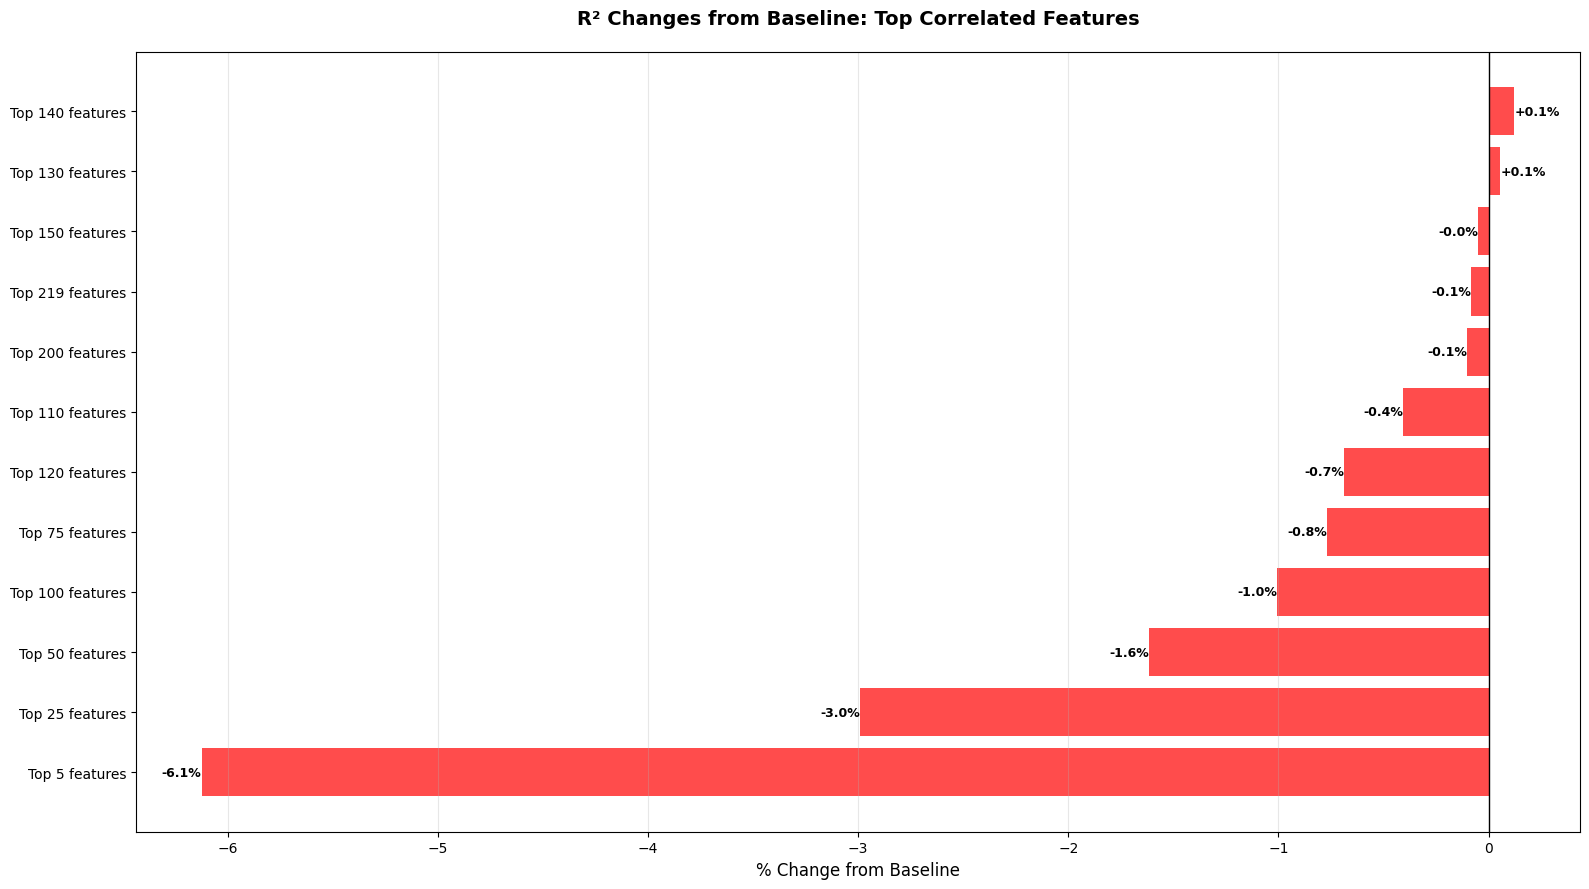

In [47]:
pct_changes_df = plot_ablation_changes(individual_df, "Top Correlated Features")
plt.show()